In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, GroupKFold, ParameterGrid
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [2]:
np.random.seed(42)

# 1. Loading in Data

In [3]:
df = pd.read_csv('../data/prediction_features.csv')

In [4]:
df.head()

,Unnamed: 0,student_id,bromp_time,behavior,affect,class,events_back_30s,events_back_60s,events_back_90s,pauses_back_60s,assessment_back_60s,events_forward_30s,events_forward_60s,events_symmetric_60s,events_symmetric_90s,pauses_symmetric_60s,time_since_last_event,most_recent_event_type
0,1,stu_ADUTBVRPHKSX,2024-05-02 20:47:51.342,ON TASK,CONCENTRATING,tc_cla_p8,0,0,0,0,0,2,4,4,4,0,600.000,NO_ACTIVITY
1,2,stu_ADUTBVRPHKSX,2024-05-02 20:49:30.335,ON TASK,CONCENTRATING,tc_cla_p8,0,1,4,0,0,0,0,1,4,0,42.335,MediaEvent
2,3,stu_ADUTBVRPHKSX,2024-05-02 20:51:10.594,ON TASK,BORED,tc_cla_p8,0,0,0,0,0,1,2,2,2,1,600.000,NO_ACTIVITY
3,4,stu_ADUTBVRPHKSX,2024-05-02 20:53:05.329,ON TASK,CONCENTRATING,tc_cla_p8,3,3,5,1,1,0,0,3,5,1,4.329,MediaEvent
4,5,stu_ADUTBVRPHKSX,2024-05-02 20:54:44.118,ON TASK,CONCENTRATING,tc_cla_p8,2,2,2,0,1,2,2,4,4,0,4.118,AssessmentItemEvent


In [5]:
df.dtypes

Unnamed: 0                  int64
student_id                 object
bromp_time                 object
behavior                   object
affect                     object
class                      object
events_back_30s             int64
events_back_60s             int64
events_back_90s             int64
pauses_back_60s             int64
assessment_back_60s         int64
events_forward_30s          int64
events_forward_60s          int64
events_symmetric_60s        int64
events_symmetric_90s        int64
pauses_symmetric_60s        int64
time_since_last_event     float64
most_recent_event_type     object
dtype: object

In [6]:
cat_cols = ['behavior', 'affect', 'class', 'most_recent_event_type']

for col in cat_cols:
    df[col] = df[col].astype('category')

In [7]:
df.dtypes

Unnamed: 0                   int64
student_id                  object
bromp_time                  object
behavior                  category
affect                    category
class                     category
events_back_30s              int64
events_back_60s              int64
events_back_90s              int64
pauses_back_60s              int64
assessment_back_60s          int64
events_forward_30s           int64
events_forward_60s           int64
events_symmetric_60s         int64
events_symmetric_90s         int64
pauses_symmetric_60s         int64
time_since_last_event      float64
most_recent_event_type    category
dtype: object

# 2. Adding individual-level aggregates

In [ ]:
# Sort by student and time first!
df = df.sort_values(['student_id', 'bromp_time']).reset_index(drop=True)

lag_features = ['events_symmetric_90s', 'events_back_60s', 'pauses_back_60s', 
                'pauses_symmetric_60s', 'time_since_last_event', 'assessment_back_60s']

for col in lag_features:
    # Mean
    df[f'student_avg_{col}'] = df.groupby('student_id')[col].transform(
        lambda x: x.shift(1).expanding().mean()
    )
    
    # STD
    df[f'student_std_{col}'] = df.groupby('student_id')[col].transform(
        lambda x: x.shift(1).expanding().std()
    )
    
    # Rolling mean (last 5)
    df[f'student_recent_{col}'] = df.groupby('student_id')[col].transform(
        lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
    )

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

df['obs_number'] = df.groupby('student_id').cumcount() + 1

Adding proper lag features (using only prior observations)...
Added 19 lag features
         student_id  obs_number  student_avg_events_symmetric_90s  \
0  stu_ADUTBVRPHKSX           1                          0.000000   
1  stu_ADUTBVRPHKSX           2                          4.000000   
2  stu_ADUTBVRPHKSX           3                          4.000000   
3  stu_ADUTBVRPHKSX           4                          3.333333   
4  stu_ADUTBVRPHKSX           5                          3.750000   
5  stu_ADUTBVRPHKSX           6                          3.800000   
6  stu_ADUTBVRPHKSX           7                          3.666667   
7  stu_ADUTBVRPHKSX           8                          3.714286   
8  stu_ADUTBVRPHKSX           9                          3.250000   
9  stu_ADUTBVRPHKSX          10                          3.333333   

   student_recent_events_symmetric_90s  
0                             0.000000  
1                             4.000000  
2                             4.0

In [9]:
df.head()

,Unnamed: 0,student_id,bromp_time,behavior,affect,class,events_back_30s,events_back_60s,events_back_90s,pauses_back_60s,...,student_avg_pauses_symmetric_60s,student_std_pauses_symmetric_60s,student_recent_pauses_symmetric_60s,student_avg_time_since_last_event,student_std_time_since_last_event,student_recent_time_since_last_event,student_avg_assessment_back_60s,student_std_assessment_back_60s,student_recent_assessment_back_60s,obs_number
0,1,stu_ADUTBVRPHKSX,2024-05-02 20:47:51.342,ON TASK,CONCENTRATING,tc_cla_p8,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,1
1,2,stu_ADUTBVRPHKSX,2024-05-02 20:49:30.335,ON TASK,CONCENTRATING,tc_cla_p8,0,1,4,0,...,0.000000,0.00000,0.000000,600.000000,0.000000,600.000000,0.00,0.0,0.00,2
2,3,stu_ADUTBVRPHKSX,2024-05-02 20:51:10.594,ON TASK,BORED,tc_cla_p8,0,0,0,0,...,0.000000,0.00000,0.000000,321.167500,394.328703,321.167500,0.00,0.0,0.00,3
3,4,stu_ADUTBVRPHKSX,2024-05-02 20:53:05.329,ON TASK,CONCENTRATING,tc_cla_p8,3,3,5,1,...,0.333333,0.57735,0.333333,414.111667,321.968038,414.111667,0.00,0.0,0.00,4
4,5,stu_ADUTBVRPHKSX,2024-05-02 20:54:44.118,ON TASK,CONCENTRATING,tc_cla_p8,2,2,2,0,...,0.500000,0.57735,0.500000,311.666000,333.300770,311.666000,0.25,0.5,0.25,5


In [10]:
df.columns

Index(['Unnamed: 0', 'student_id', 'bromp_time', 'behavior', 'affect', 'class',
       'events_back_30s', 'events_back_60s', 'events_back_90s',
       'pauses_back_60s', 'assessment_back_60s', 'events_forward_30s',
       'events_forward_60s', 'events_symmetric_60s', 'events_symmetric_90s',
       'pauses_symmetric_60s', 'time_since_last_event',
       'most_recent_event_type', 'student_avg_events_symmetric_90s',
       'student_std_events_symmetric_90s',
       'student_recent_events_symmetric_90s', 'student_avg_events_back_60s',
       'student_std_events_back_60s', 'student_recent_events_back_60s',
       'student_avg_pauses_back_60s', 'student_std_pauses_back_60s',
       'student_recent_pauses_back_60s', 'student_avg_pauses_symmetric_60s',
       'student_std_pauses_symmetric_60s',
       'student_recent_pauses_symmetric_60s',
       'student_avg_time_since_last_event',
       'student_std_time_since_last_event',
       'student_recent_time_since_last_event',
       'student_avg_a

## 2.2 Making deviation features

In [ ]:
df['events_deviation_90s'] = df['events_symmetric_90s'] - df['student_avg_events_symmetric_90s']
df['events_deviation_60s'] = df['events_back_60s'] - df['student_avg_events_back_60s']
df['time_since_deviation'] = df['time_since_last_event'] - df['student_avg_time_since_last_event']
df['pauses_deviation'] = df['pauses_back_60s'] - df['student_avg_pauses_back_60s']
df['pause_rate_60s'] = np.where(df['events_back_60s'] > 0,
                                 df['pauses_back_60s'] / df['events_back_60s'],
                                 0)

# Ratio to baseline
df['events_ratio_90s'] = df['events_symmetric_90s'] / (df['student_avg_events_symmetric_90s'] + 1)

# Deviation from RECENT baseline (last 5)
df['events_deviation_recent'] = df['events_symmetric_90s'] - df['student_recent_events_symmetric_90s']

In [12]:
df[['student_id', 'events_deviation_90s', 'events_deviation_60s', 
          'time_since_deviation', 'pauses_deviation', 'events_ratio_90s', 'events_deviation_recent']].head()

,student_id,events_deviation_90s,events_deviation_60s,time_since_deviation,pauses_deviation,events_ratio_90s,events_deviation_recent
0,stu_ADUTBVRPHKSX,4.000000,0.000000,600.000000,0.00,4.000000,4.000000
1,stu_ADUTBVRPHKSX,0.000000,1.000000,-557.665000,0.00,0.800000,0.000000
2,stu_ADUTBVRPHKSX,-2.000000,-0.500000,278.832500,0.00,0.400000,-2.000000
3,stu_ADUTBVRPHKSX,1.666667,2.666667,-409.782667,1.00,1.153846,1.666667
4,stu_ADUTBVRPHKSX,0.250000,1.000000,-307.548000,-0.25,0.842105,0.250000


In [13]:
df.columns

Index(['Unnamed: 0', 'student_id', 'bromp_time', 'behavior', 'affect', 'class',
       'events_back_30s', 'events_back_60s', 'events_back_90s',
       'pauses_back_60s', 'assessment_back_60s', 'events_forward_30s',
       'events_forward_60s', 'events_symmetric_60s', 'events_symmetric_90s',
       'pauses_symmetric_60s', 'time_since_last_event',
       'most_recent_event_type', 'student_avg_events_symmetric_90s',
       'student_std_events_symmetric_90s',
       'student_recent_events_symmetric_90s', 'student_avg_events_back_60s',
       'student_std_events_back_60s', 'student_recent_events_back_60s',
       'student_avg_pauses_back_60s', 'student_std_pauses_back_60s',
       'student_recent_pauses_back_60s', 'student_avg_pauses_symmetric_60s',
       'student_std_pauses_symmetric_60s',
       'student_recent_pauses_symmetric_60s',
       'student_avg_time_since_last_event',
       'student_std_time_since_last_event',
       'student_recent_time_since_last_event',
       'student_avg_a

# 3. Creating target variable

In [14]:
df['engaged'] = df['behavior'].apply(
    lambda x: 'ENGAGED' if x in ['ON TASK', 'ON TASK CONV'] else 'DISENGAGED'
)

df['engaged'].value_counts()

engaged
ENGAGED       3029
DISENGAGED    1008
Name: count, dtype: int64

In [15]:
engagement_map = {'DISENGAGED': 0, 'ENGAGED': 1}

df['engaged'] = df['engaged'].map(engagement_map).astype('category')

# 4. Preparing Features

In [16]:
deviation_ft = [
    'events_deviation_90s',
    'events_deviation_60s', 
    'time_since_deviation',
    'pauses_deviation',
    'events_ratio_90s',
    'events_deviation_recent',
    'pause_rate_60s'
]

backward_ft = [
    'events_back_30s',
    'events_back_60s',
    'events_back_90s',
    'pauses_back_60s',
    'assessment_back_60s',
    'time_since_last_event'
]

symmetric_ft = [
    'events_symmetric_60s',
    'events_symmetric_90s',
    'pauses_symmetric_60s'
]

baseline_ft = [
    'student_avg_events_symmetric_90s',
    'student_std_events_symmetric_90s',
    'student_recent_events_symmetric_90s',
    'student_avg_time_since_last_event',
    'student_avg_pauses_back_60s',
    'student_avg_assessment_back_60s',
    'obs_number'
]

features = deviation_ft + backward_ft + symmetric_ft + baseline_ft

In [17]:
df_full = df[['student_id', 'bromp_time', 'behavior', 'affect']].copy() # This is for visualization later

X = df[features].copy()
y = df['engaged'].astype(int)
groups = df['student_id'].copy()

# 4. Train Test Split

In [18]:
# POTENTIAL FLAG FOR DELETION
# THIS CHUNK IS SO THAT THE MODEL WOULD TRAIN ON OBSERVATIONS WITH ACTIVITY ONLY

df = df[df['events_symmetric_90s'] > 0].copy()

We want to split by sutdents, not by observations, in order to prevent data leakage.

In [19]:
unique_students = groups.unique()
train_students, test_students = train_test_split(
    unique_students, 
    test_size=0.2, 
    random_state=42
)

In [20]:
train_mask = groups.isin(train_students)
test_mask = groups.isin(test_students)

X_temp = X[train_mask]
y_temp = y[train_mask]
groups_temp = groups[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]

In [21]:
# Need to do this ^ again to split `_temp` into train and validation

temp_unique_students = groups_temp.unique()
train_students_final, val_students = train_test_split(
    temp_unique_students,
    test_size=0.2,
    random_state=42
)

train_mask = groups_temp.isin(train_students_final)
val_mask = groups_temp.isin(val_students)

X_train = X_temp[train_mask]
y_train = y_temp[train_mask]
groups_train = groups_temp[train_mask]

X_val = X_temp[val_mask]
y_val = y_temp[val_mask]
groups_val = groups_temp[val_mask]

# 5. Get tuning with Student-Level GroupKFold CV

In [23]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [24]:
y_train.value_counts()

engaged
1    1942
0     675
Name: count, dtype: int64

In [ ]:
# Parameter gird + CV setting

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'colsample_bylevel': [0.6, 0.7, 0.8],
    'scale_pos_weight': [0, scale_pos_weight]
}

cv_setting = GroupKFold(n_splits=5)

In [ ]:
param_combos = list(ParameterGrid(param_grid))
total_folds = len(param_combos) * cv_setting.get_n_splits(X_train, y_train, groups_train)

# best_score = -np.inf
# best_params = None

In [ ]:
# # Actual tuning using XGBoost

# with tqdm(total=total_folds, desc="Grid Search Progress", ncols=100) as pbar:
#     for i, params in enumerate(param_combos, start=1):
#         model_params = params.copy()
#         fold_scores = []

#         for train_idx, val_idx in cv_setting.split(X_train, y_train, groups_train):
#             X_tr, X_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
#             y_tr, y_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

#             model = XGBClassifier(**model_params, random_state=42,
#                                   eval_metric='aucpr', enable_categorical=True)
#             model.fit(X_tr.values, y_tr.values)

#             preds = model.predict_proba(X_cv.values)[:, 1]
#             fold_auc = roc_auc_score(y_cv.values, preds)
#             fold_scores.append(fold_auc)

#             pbar.update(1)
#             pbar.set_postfix({
#                 'params': f"{i}/{len(param_combos)}",
#                 'mean_auc': f"{np.mean(fold_scores):.4f}"
#             })

#         mean_auc = np.mean(fold_scores)
#         if mean_auc > best_score:
#             best_score = mean_auc
#             best_params = params

# pbar.close()

# print(f"\nBest params from CV: {best_params}")
# print(f"Best mean AUROC (train CV): {best_score:.4f}")

# os.system('afplay /System/Library/Sounds/Glass.aiff')

Grid Search Progress: 100%|█| 12960/12960 [30:38<00:00,  7.05it/s, params=2592/2592, mean_auc=0.6407



Best params from CV: {'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': np.float64(0.34757981462409887), 'subsample': 0.7}
Best mean AUROC (train CV): 0.6774


0

In [28]:
# # Training final model

# final_model_params = {k: v for k, v in best_params.items() if k != 'pos_weight'}

# final_model = XGBClassifier(**final_model_params, random_state=42, eval_metric='aucpr')
# final_model.fit(X_train.values, y_train.values)

In [ ]:
# joblib.dump([final_model, final_model_params], 'caches/lagft_model.pkl')

['caches/lagft_model.pkl']

In [29]:
final_model, final_model_params = joblib.load('caches/lagft_model.pkl')
final_model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [31]:
y_pred_val = final_model.predict(X_val.values)
y_proba_val = final_model.predict_proba(X_val.values)[:, 1]

val_auc = roc_auc_score(y_val, y_proba_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Set Results:")
print(f"AUC: {val_auc:.4f}")
print(f"F1:  {val_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, target_names=['DISENGAGED', 'ENGAGED']))


Validation Set Results:
AUC: 0.6323
F1:  0.8020

Classification Report:
              precision    recall  f1-score   support

  DISENGAGED       0.33      0.47      0.39       132
     ENGAGED       0.85      0.76      0.80       520

    accuracy                           0.70       652
   macro avg       0.59      0.61      0.60       652
weighted avg       0.74      0.70      0.72       652



In [32]:
# Threshold tuning

precision, recall, thresholds = precision_recall_curve(y_val, y_proba_val)

f1s = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print(f"Best F1 threshold: {best_threshold:.3f}, F1 = {f1s[best_idx]:.3f}")

Best F1 threshold: 0.123, F1 = 0.889


In [33]:
y_pred_val = (y_proba_val >= best_threshold).astype(int)
y_proba_val = final_model.predict_proba(X_val.values)[:, 1]

val_auc = roc_auc_score(y_val, y_proba_val)
val_f1 = f1_score(y_val, y_pred_val)

print("\nValidation Set Results:")
print(f"AUC: {val_auc:.4f}")
print(f"F1:  {val_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, target_names=['DISENGAGED', 'ENGAGED']))


Validation Set Results:
AUC: 0.6323
F1:  0.8891

Classification Report:
              precision    recall  f1-score   support

  DISENGAGED       0.61      0.08      0.15       132
     ENGAGED       0.81      0.99      0.89       520

    accuracy                           0.80       652
   macro avg       0.71      0.53      0.52       652
weighted avg       0.77      0.80      0.74       652



# 6. Testing

In [34]:
X_temp = pd.concat([X_train, X_val])
y_temp = pd.concat([y_train, y_val])

final_model.fit(X_temp.values, y_temp.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]
# y_pred_test = (y_proba_test >= best_threshold).astype(int)

test_auc = roc_auc_score(y_test, y_proba_test)
test_f1 = f1_score(y_test, y_pred_test)

print("\nTest Set Results:")
print(f"AUC: {test_auc:.4f}")
print(f"F1:  {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['DISENGAGED', 'ENGAGED']))


Test Set Results:
AUC: 0.6385
F1:  0.7975

Classification Report:
              precision    recall  f1-score   support

  DISENGAGED       0.43      0.42      0.42       201
     ENGAGED       0.80      0.80      0.80       567

    accuracy                           0.70       768
   macro avg       0.61      0.61      0.61       768
weighted avg       0.70      0.70      0.70       768



In [36]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nBest CV AUC (train):  {best_score:.4f}")
print(f"Validation AUC:       {val_auc:.4f}")
print(f"Test AUC:             {test_auc:.4f}")
print(f"\nBest parameters: {best_params}")
print("="*60)

FINAL SUMMARY

Best CV AUC (train):  -inf
Validation AUC:       0.6323
Test AUC:             0.6385

Best parameters: None


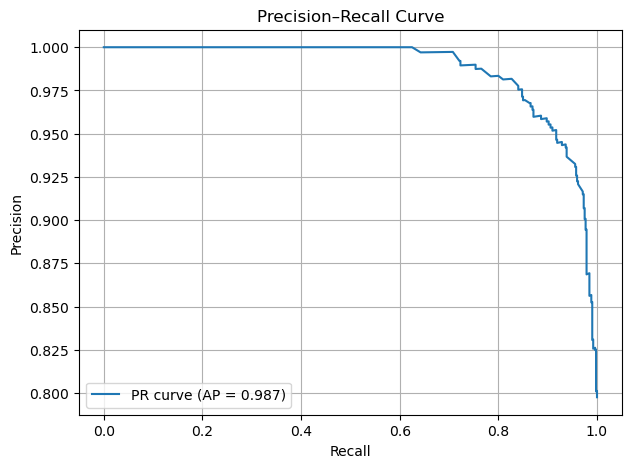

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for class 1
y_proba = final_model.predict_proba(X_val)[:, 1]

# Compute precision–recall pairs
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Compute the area under the curve (Average Precision)
ap = average_precision_score(y_val, y_proba)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


Best F1 threshold: 0.403, F1 = 0.944


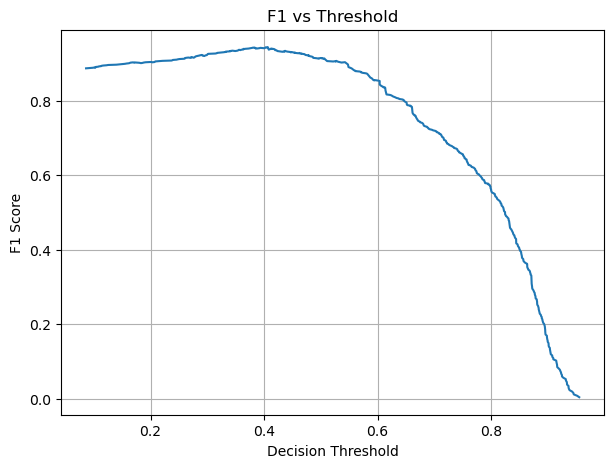

In [38]:
import numpy as np
from sklearn.metrics import f1_score

f1s = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print(f"Best F1 threshold: {best_threshold:.3f}, F1 = {f1s[best_idx]:.3f}")

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s[:-1])
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()


In [39]:
# # Uncomment if you want the ROC Curve visualization

# fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
# auc_score = roc_auc_score(y_test, y_proba_test)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

In [40]:
# # Uncomment if you want to see plot_tree

# os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

# fig, ax = plt.subplots(figsize=(100, 80))
# plot_tree(final_model, ax=ax)
# plt.show()

# 7. Exporting Results for Visualization and for Fun

## 7.1. Feature Importance

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

In [56]:
def categorize_feature(feature_name):
    if 'student_avg' in feature_name or 'student_std' in feature_name or 'student_recent' in feature_name:
        return 'Student Baseline (Lag Features)'
    elif 'deviation' in feature_name or 'ratio' in feature_name:
        return 'Deviation from Baseline'
    elif 'back' in feature_name or 'symmetric' in feature_name or 'forward' in feature_name:
        return 'Raw Activity Windows'
    elif 'pause' in feature_name:
        return 'Pause Behavior'
    elif 'assessment' in feature_name:
        return 'Assessment Activity'
    elif 'time_since' in feature_name:
        return 'Time Since Last Event'
    elif 'obs_number' in feature_name:
        return 'Observation Sequence'
    else:
        return 'Other'

feature_importance['category'] = feature_importance['feature'].apply(categorize_feature)

In [57]:
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()
feature_importance['importance_pct'] = (feature_importance['importance'] / feature_importance['importance'].sum() * 100).round(2)

In [ ]:
feature_importance.to_csv('../outputs/figures/data/page1_feature_importance.csv', index=False)

## 7.2. Prediction Confidence

In [59]:
prediction_confidence = pd.DataFrame({
    'predicted_probability': y_proba_test,
    'actual_engaged': y_test.reset_index(drop=True).values,
    'predicted_engaged': y_pred_test,
    'correct': (y_pred_test == y_test.reset_index(drop=True).values).astype(int)
})

In [ ]:
# Conf bins
prediction_confidence['confidence_bin'] = pd.cut(
    prediction_confidence['predicted_probability'], 
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
)

# Adding pred type (e.g. TP, FP)
def get_pred_type(row):
    if row['actual_engaged'] == 1 and row['predicted_engaged'] == 1:
        return 'True Positive'
    elif row['actual_engaged'] == 0 and row['predicted_engaged'] == 0:
        return 'True Negative'
    elif row['actual_engaged'] == 1 and row['predicted_engaged'] == 0:
        return 'False Negative'
    else:
        return 'False Positive'

prediction_confidence['prediction_type'] = prediction_confidence.apply(get_pred_type, axis=1)

In [ ]:
prediction_confidence.to_csv('../outputs/figures/data/page1_prediction_confidence.csv', index=False)

## 7.3. Performance Summary

In [62]:
from sklearn.metrics import precision_score, recall_score

In [63]:
baseline_accuracy = y_test.value_counts().max() / len(y_test)

performance_metrics = pd.DataFrame({
    'metric': [
        'Test AUC',
        'Test Accuracy', 
        'Validation AUC',
        'Validation Accuracy',
        'CV AUC (Train)',
        'Baseline Accuracy',
        'Test F1 Score',
        'Test Precision (ENGAGED)',
        'Test Recall (ENGAGED)',
        'Test Precision (DISENGAGED)',
        'Test Recall (DISENGAGED)'
    ],
    'value': [
        roc_auc_score(y_test, y_proba_test),
        accuracy_score(y_test, y_pred_test),
        roc_auc_score(y_val, y_proba_val),
        accuracy_score(y_val, y_pred_val),
        0.6774, 
        baseline_accuracy,
        f1_score(y_test, y_pred_test),
        precision_score(y_test, y_pred_test, pos_label=1),
        recall_score(y_test, y_pred_test, pos_label=1),
        precision_score(y_test, y_pred_test, pos_label=0),
        recall_score(y_test, y_pred_test, pos_label=0)
    ]
})

In [ ]:
performance_metrics['value'] = performance_metrics['value'].round(3)
performance_metrics.to_csv('../outputs/figures/data/page1_performance_metrics.csv', index=False)

## 7.4. Category-Level Feature Importance

In [65]:
category_importance = feature_importance.groupby('category').agg({
    'importance': 'sum',
    'feature': 'count'
}).reset_index()

In [66]:
category_importance.columns = ['category', 'total_importance', 'num_features']
category_importance = category_importance.sort_values('total_importance', ascending=False)
category_importance['importance_pct'] = (category_importance['total_importance'] / 
                                          category_importance['total_importance'].sum() * 100).round(2)

In [ ]:
category_importance.to_csv('../outputs/figures/data/page1_category_importance.csv', index=False)